# Contents

__[1. Loading data](#1.-Loading-data)__  

__[2. Exploratory data analysis  ](#2.-Exploratory-data-analysis)__  

__[3. Preprocessing](#3.-Preprocessing)__  

__[4. Modeling](#4.-Modeling)__  
    [4.1. K Nearest Neighbors](#4.1.-K-Nearest-Neighbors)  
    [4.2. Decision Tree](#4.2.-Decision-Tree)  
    [4.3. Support Vector Machine](#4.3-Support-Vector-Machine)  
    [4.4. Logistic Regression](#4.4.-Logistic-Regression)  
    
__[5. Model Evaluation using Test set](#5.-Model-Evaluation-using-Test-set)__  


***

# 1. Loading data

This data set includes customers who have paid off their loans, who have been past due and put into collection without paying back their loan and interests, and who have paid off only after they were put in collection. The financial product is a bullet loan that customers should pay off all of their loan debt in just one time by the end of the term, instead of an installment schedule. Of course, they could pay off earlier than their pay schedule.

The dataset includes details of 500 customers whose loan are already paid off or defaulted. It includes following __variables__:

| Variable          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_id        | A unique loan number assigned to each loan customers
| Loan_status    | Whether a loan is paid off, in collection, new customer yet to payoff, or paid off after the collection efforts                                           |
| Principal      | Basic principal loan amount at the origination                                                    |
| terms          | Can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Paidoff_time   | The actual time a customer pays off the loan
| Pastdue_days   | How many days a loan has been past due
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

In [2]:
import pandas as pd
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing

# load tools
import utils as u
import functions as f
import classification as c

In [3]:
df0 = pd.read_csv("data.csv")
print(f"Number of observations: ", df0.shape[0])
print(f"Number of variables, including the response: ", df0.shape[1])
df0.head()


Number of observations:  500
Number of variables, including the response:  11


,Loan_ID,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
0,xqd20166231,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/14/2016 19:31,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,9/8/2016,10/7/2016,10/7/2016 9:00,NaN,50,Bechalor,female
2,xqd20160003,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/25/2016 16:58,NaN,33,Bechalor,female
3,xqd20160004,PAIDOFF,1000,15,9/8/2016,9/22/2016,9/22/2016 20:00,NaN,27,college,male
4,xqd20160005,PAIDOFF,1000,30,9/9/2016,10/8/2016,9/23/2016 21:36,NaN,28,college,female


***

# 2. Exploratory data analysis  

As a part of exploratory data analysis, we can look at __statistical description__ of the dataset.

Quick analysis of the data shows the following:
- There are __8 categorical and 3 numerical variables__.
- 7% of cells are __missing values__.
- There are __no duplicate rows__.
- `Loan_ID` is unique for each observation and __doesn't add necessary information__ to analysis.
- __The response__ (`loan_status`) is categorical and __has 3 values__:  PAIDOFF - customer paid before the due date, COLLECTION - the due date is over, but the loan is still not paid off, COLLECTION_PAIDOFF the loan was paid off after the collection date. There are more paidoff loans than unpaid ones or paid after collection.
- There are only 6 distinct values for `Principal`, however, it is recognised as numerical variable.
- There are 3 values for `terms`; only 21 observations are present in the weekly payoff schedule category, which is much less than in other categories.
- `effective_date`, `due_date`, `paid_off_time` are recognised as categorical variables instead of dates.
- There are __300 missing values in `past_due_days`__, because this variable is connected with unpaid loans only.
- Age ranges from 18 to 51 years, the average age is 31, the distribution looks normal.
- `Education` has 4 categories: High School or below, college, bachelor and master; bachelor and master have the least observations.
- There are __much more males than females__ in the dataset.

Overall, the __dataset is unbalanced__ as the number of observations for different categories varies. This may make estimation of the effect of the class with less observations difficult. The mising values also are problematic.

In [4]:
f.get_overview(df0)

We can take a closer look at the data.

In [5]:
f.get_summary(df0,
                y=df0.loan_status,
                nan=True,
                formats=True,
                categorical=True)

NaNs:  ['paid_off_time', 'past_due_days']
Unique formats:  [dtype('O'), dtype('int64'), dtype('float64')]
Possible categorical variables (<10 unique values):  ['loan_status', 'Principal', 'terms', 'effective_date', 'education', 'Gender']


1. The missing values are in __variables `paid_off_time`, `past_due_days`__: 
    - NaNs appear in `paid_off_time` because the loan is still not paid off, so the date is unknown.
    - NaNs appear in `past_due_days` because the loan was paid off in time.
    So, the `past_due_days` column has no missing values only when the loan is paid off after collection, or `loan status` is COLLECTION_PAIDOFF.   
<br>
2. We need to __correct formats__ of the categorical variables.  
<br>
3. There are several numerical variables which may be considered as categorical. In particular, terms, effective_date, education, Gender can be __changed into categorical values__ and encoded using one hot encoding.  

***
# 3. Preprocessing  

Based on the above, we will create a preprocessing pipeline for this dataset:
1. We will correct __dates formats__.  
<br>
1. __Convert categorical__ varables to binary variables. Bin days of the week based on effective date: 1 - moday, ... , 7 - sunday. For `education` we will get dummies and make 'Bachelor' value the baseline level.  
<br>
1. __Fill missing values in `past_due_days` with zeroes__, because the missing values mean that loan was paid in time. We will also drop `paid_off_time`, because it is a linear combination of `past_due_days` and `effective_date`, and `due_date`, because it is a linear combination of `terms` and `effective_date`.  
<br>  
1. Form a __feature vector__.  
<br>


In [7]:
df = df0.copy()

def preprocess(df):
    
    ## 1 DATES
    
    # correct dates
    df = u.to_dates(df, ['due_date', 'effective_date','paid_off_time'])
    # keep only date
    df['paid_off_time'] = df['paid_off_time'].dt.date
    
    ## 2 ENCODING CATEGORICAL VARIABLES
    
    #transform gender: males = 0, females = 1
    df['Gender'].replace(to_replace=['male', 'female'], value=[0,1], inplace=True)
    #transform loan_status: PAIDOFF = 0, COLLECTION_PAIDOFF = 1, COLLECTION = 2 
    df['loan_status'].replace(to_replace=['PAIDOFF', 'COLLECTION_PAIDOFF','COLLECTION'], value=[0, 1, 2], inplace=True)
    
    #Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame
    # do not include first column on the dummies to avoid over-parameterisation
    
    df = pd.concat([df, pd.get_dummies(df['education']).iloc[:, 1:]], axis=1)
    #drop education because we have dummies for it as separate columns
    df.drop(['education'], axis = 1, inplace=True)

    #binning days of the week based on effective date: 1 - moday, ... , 7 - sunday
    df['effective_weekbins'] = df['effective_date'].dt.dayofweek+1

    ## 3 FILL MISSING VALUES with 0 in past_due_days
    df.past_due_days.fillna(0, inplace=True)
    
    ## 4 Labels and features
    
    X_names = ['Principal','terms','past_due_days','age','Gender','High School or Below','Master or Above','college','effective_weekbins']
    y_names = 'loan_status'
    all_names = X_names[:]
    all_names.append(y_names)
    df_out = df[all_names]
    X = df_out[X_names]
    y = df_out[y_names]

    return df_out, X, y, X_names, y_names

df, X, y, X_names, y_names = preprocess(df)

We can look for outliers in the feature vector using __z-score__. They are marked as red dots on the plots below, where X-axis - observation number and Y-axis - variable name.

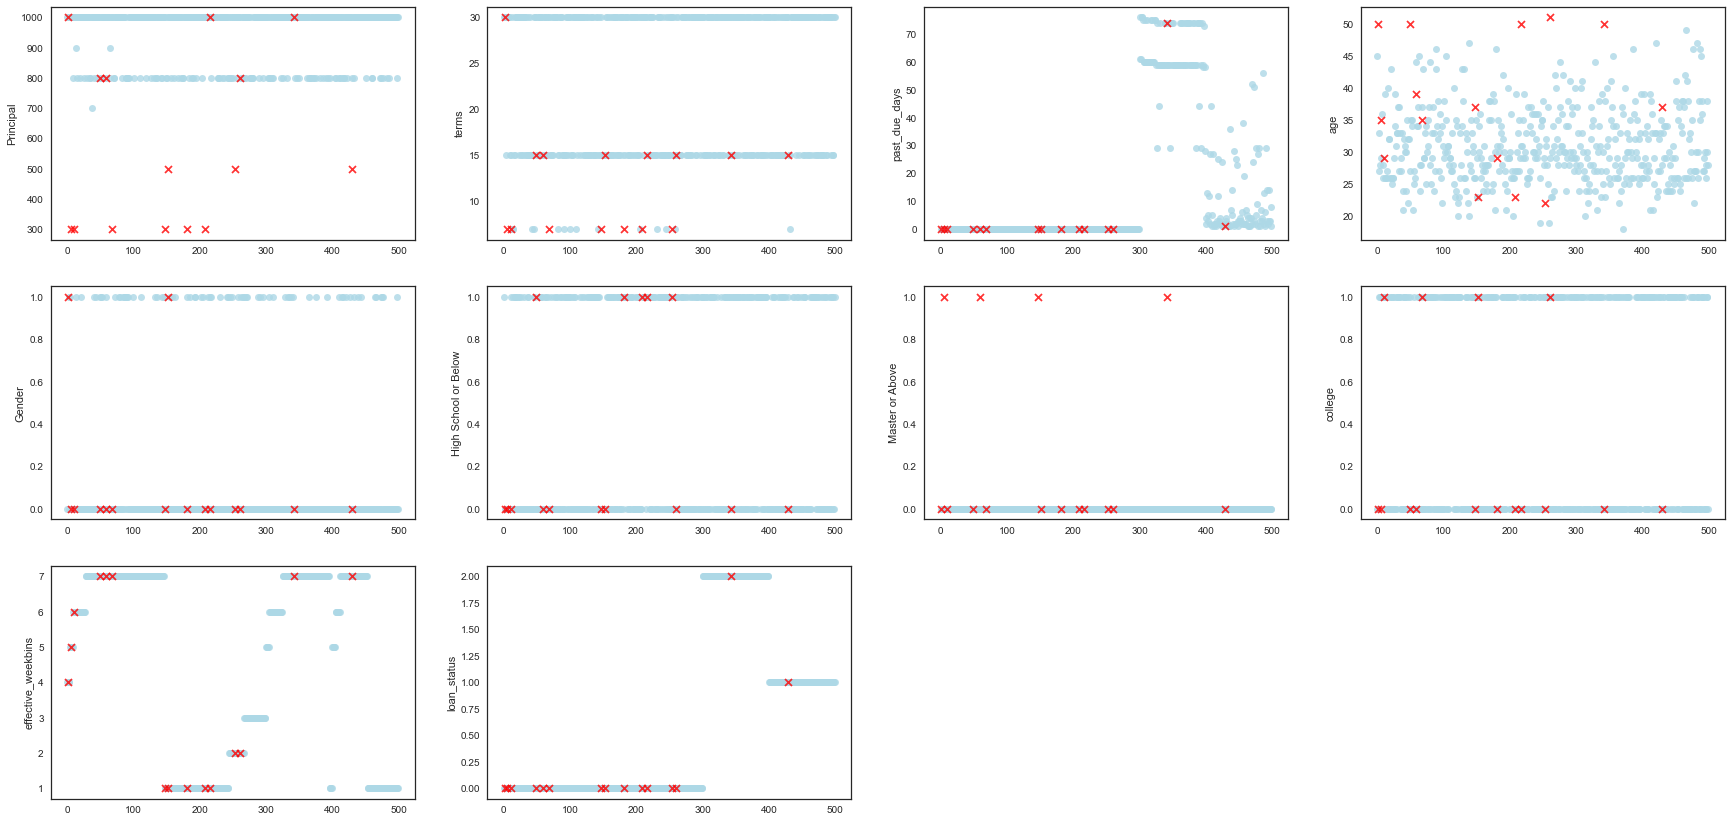

In [8]:
reload(f)
df_clean, df_outliers, df_marked = f.show_outliers(df, 
                                                   df.columns,
                                                   how='z_score', show_plot=True, threshold=3)

We have found __15 outliers__. Observations that are marked as outliers are those with small principal, masters degree or above, high value of age. Analysis of these outliers did not show that these datapoints are erroneous, in fact, due to imblance of the dataset as shown in the previous section, the observations belonging to unpopular category are marked as outliers. Since we have only 500 observations, we will __leave them in the dataset for now__, as removing them may worsen the imbalance of the data.

***
# 4. Modeling

This is the __classification task__, whcih we will solve using the following methods:
- K-Nearest Neighbors
- Decision Tree
- Support Vector Machine
- Logistic Regression

First, we will split the dataset into __training, validation and testing sets__:  
- training set will be used to fit the parameters of the model;
- validation set will be used to tune hyperparameters;
- testing set provides an unbiased evaluation of a final model.

In [92]:
from sklearn.model_selection import train_test_split

# first, we will randomly select the testing set
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# now we will split the dataset into training and validation sets
# we use stratify=y, because we have unbalanced dataset 
# and we want to keep the proportion of y values through the training and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y_tv, test_size=0.2, random_state=4, stratify=y_tv)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Validation set:', X_valid.shape,  y_valid.shape)
print ('Test set:', X_test.shape,  y_test.shape)

u.check(X_test.shape[0] + X_valid.shape[0] + X_train.shape[0] == X.shape[0], 'Split is correct')

Train set: (320, 9) (320,)
Validation set: (80, 9) (80,)
Test set: (100, 9) (100,)
PASSED. Split is correct


As we noticed earlier, there is a problem of imbalanced dataset: there are much more people who paid the loan in time than those who didn't. To deal with it, we will use one of the resampling techniques — we will oversample minority classes.

In [93]:
from sklearn.utils import resample

# concatenate our training data back together
df_train = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
df_loan_status0 = df_train[df_train.loan_status==0]
df_loan_status1 = df_train[df_train.loan_status==1]  # COLLECTION_PAIDOFF 
df_loan_status2 = df_train[df_train.loan_status==2]  # COLLECTION

# upsample minority
upsampled1 = resample(df_loan_status1,
                          replace=True, # sample with replacement
                          n_samples=len(df_loan_status0), # match number in majority class
                          random_state=1) # reproducible results
upsampled2 = resample(df_loan_status2,
                          replace=True, # sample with replacement
                          n_samples=len(df_loan_status0), # match number in majority class
                          random_state=1) # reproducible results

# combine majority and upsampled minority
df_upsampled = pd.concat([df_loan_status0, upsampled1, upsampled2])

# equal ratio of data points for each class
print(df_upsampled.loan_status.value_counts())

# separate predictor from other variables
y_train = df_upsampled[y_train.name]
X_train = df_upsampled.loc[:, df_upsampled.columns != y_train.name]

2    187
1    187
0    187
Name: loan_status, dtype: int64


## 4.1. K Nearest Neighbors



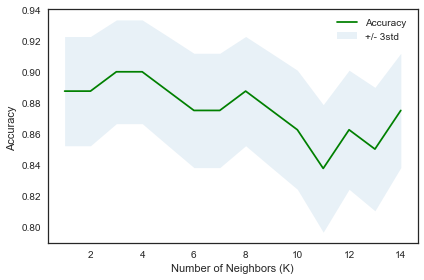

Best k out of 15 is 3 with accuracy 0.9


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [94]:
#find best k out of 15
Ks=15
kNN_model = c.knn_findk(Ks, X_train, y_train, X_valid, y_valid)
kNN_model.fit(X_train,y_train)


## 4.2. Decision Tree

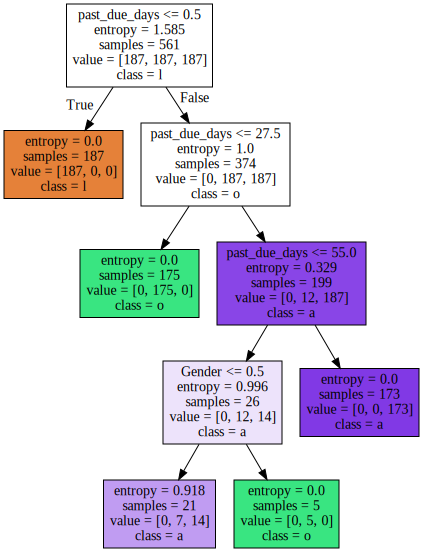

In [95]:
from sklearn.tree import DecisionTreeClassifier
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DT_model.fit(X_train,y_train)
c.plot_decisionTrees(DT_model, X_names, y_names)
# yhat = DT_model.predict(X_valid)


## 4.3. Support Vector Machine

Confusion matrix, without normalization


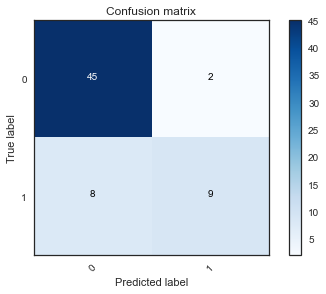

In [96]:
from sklearn import svm
SVM_model = svm.SVC()
SVM_model.fit(X_train, y_train) 

yhat = SVM_model.predict(X_valid)
c.plot_confusion_matrix(y_valid, yhat, labels=[0,1], normalize= False,  title='Confusion matrix')

# yhat = SVM_model.predict(X_valid)

## 4.4. Logistic Regression

Confusion matrix, without normalization


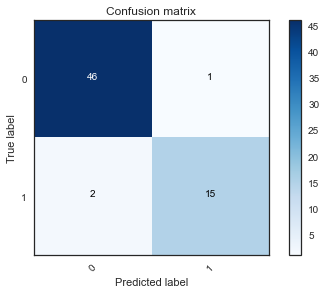

In [97]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)
yhat = LR_model.predict(X_valid)
# yhat_prob = LR_model.predict_proba(X_valid)  #  returns estimates for all classes, ordered by the label of classes.
c.plot_confusion_matrix(y_valid, yhat, labels=[0,1], normalize= False,  title='Confusion matrix')
# print (classification_report(y_valid, yhat))


***
# 5. Model Evaluation using Test set  


In [98]:
f.metrics(kNN_model, X_test, y_test)
f.metrics(DT_model, X_test, y_test)
f.metrics(SVM_model, X_test, y_test)
f.metrics(LR_model, X_test, y_test)

KNeighborsClassifier
Jaccard index: 0.89
F1-score: 0.89

DecisionTreeClassifier
Jaccard index: 0.97
F1-score: 0.97

SVC
Jaccard index: 0.89
F1-score: 0.89

LogisticRegression
Jaccard index: 0.95
F1-score: 0.95
LogLoss: 0.45

